# DS-GA 3001.009 Modeling Time Series Data

# Week 11 Gaussian Process Application

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import warnings
import itertools
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel as WK,\
ExpSineSquared as ESS, RationalQuadratic as RQ, Matern as M
from sklearn.gaussian_process.kernels import DotProduct

plt.style.use('fivethirtyeight')

## Part I: Kernel Exploration

In [137]:
def explore_kernel(k, x_0 = 0):
    x=np.arange(-40, 40).reshape(-1, 1)
    zeros = np.ones((1,1)) * x_0
    y = k(zeros, x)
    plt.plot(x, y.T)
    plt.xlabel("x")
    plt.ylabel("k({0},x)".format(x_0))
    plt.title("Value of k({0}, x)".format(x_0))
    plt.show()

Squared Exponential (SE) Kernel 

Also named Radius Basis Function (RBF)

$$k(x, x') = \sigma^2 exp(-\frac{(x-x')^2}{2l^2})$$

Hyper-parameters: $\sigma, l$
- $\sigma$ controls the magnitude
- $l$ controls the bandwith

It's a "universal" kernel. Every function in its prior has infinitely many derivatives.

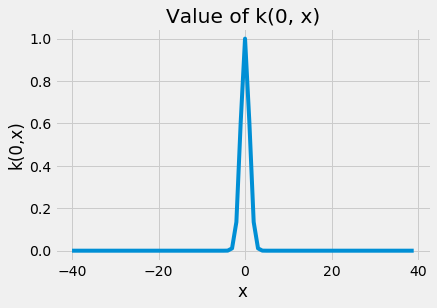

In [138]:
explore_kernel(RBF(length_scale=1))

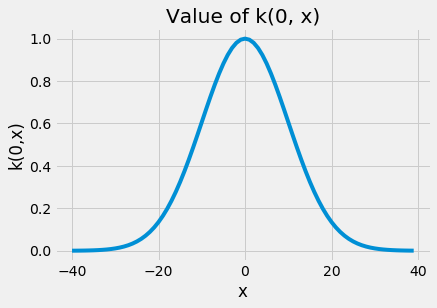

In [139]:
explore_kernel(RBF(length_scale=10))

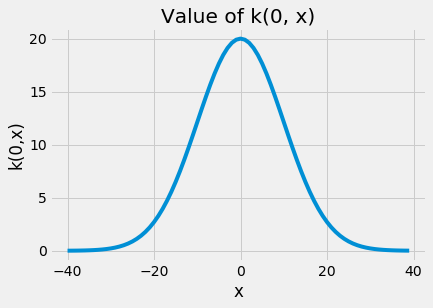

In [140]:
explore_kernel(20*RBF(length_scale=10))

Linear Kernel

$$k(x, x') = \sigma^2 (x - c)(x' - c) + \sigma_0^2 $$

Without loss of generality, sklearn assumes c = 0.

Hyper-parameter: $\sigma_0$ controls intercept.

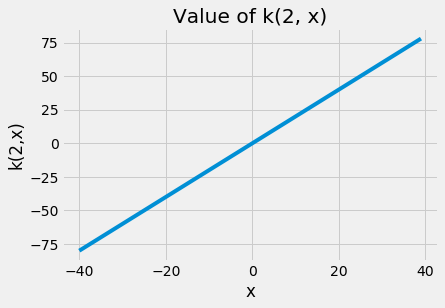

In [143]:
explore_kernel(DotProduct(sigma_0=0.0), x_0 = 2)

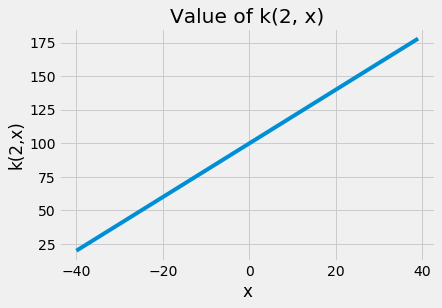

In [144]:
explore_kernel(DotProduct(sigma_0=10), x_0 = 2)

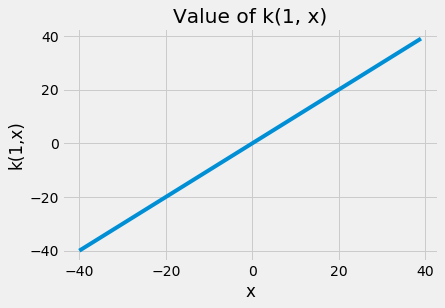

In [146]:
explore_kernel(DotProduct(sigma_0=0), x_0 = 1)

Matern Kernel

The expression is complicated. Please take a look at https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function.

Hyper-parameters: $l, \nu$.
- $l$ controls the bandwith
- $\nu$ controls the smoothieness of the function family. The larger $\nu$ is, the smoothier the function family is. When $\nu = \infty$, it becomes SE.


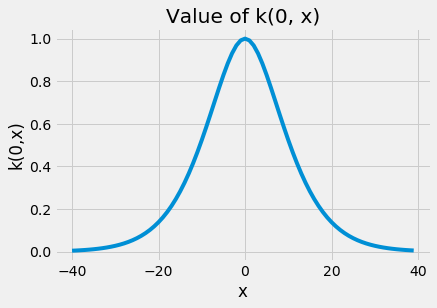

In [153]:
explore_kernel(M(length_scale=10, nu=2.5))

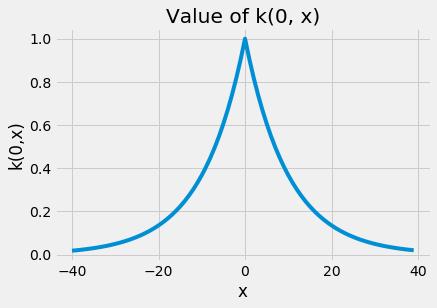

In [155]:
explore_kernel(M(length_scale=10, nu=0.5))

Rational Quadratic Kernel

$$k(x, x') = \sigma^2 + (1+\frac{(x - x')^2}{2l^2\alpha})^{-\alpha}$$

The weighted sum of a collection of SE kernels with different scale ($\sigma$).

Hyper-parameters:
- $l$ controls the bandwith
- $\alpha$ controls the weights distributed on large and small scales. The smaller the $\alpha$ the more weights on large scale.

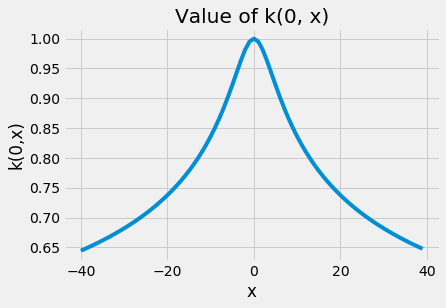

In [164]:
explore_kernel(RQ(length_scale=10.0, alpha=0.1))

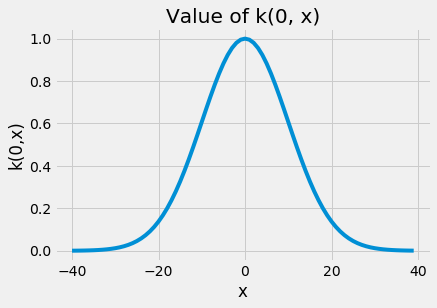

In [163]:
explore_kernel(RQ(length_scale=10.0, alpha=100))

Squared Exponential Kernel

Sometimes called Exponential Sine Squared (ESS) kernel.

$$k(x_i, x_j) = exp(-\frac{2}{l} sin^2( \frac{\pi (x - x')}{p} )$$

Models periocity within the data.

Hyper-parameters: $l, p$
- $l$ control the bandwith
- $p$ controls the frequency. The larger $p$ is, the higher the frequency.



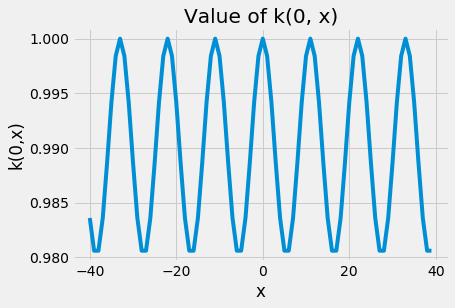

In [194]:
explore_kernel(ESS(length_scale=10, periodicity=1.1))

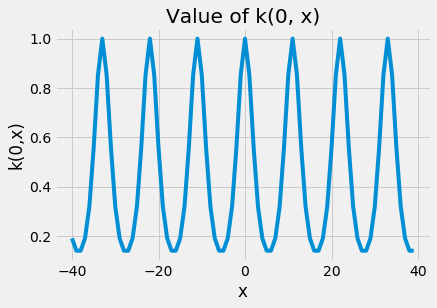

In [195]:
explore_kernel(ESS(length_scale=1, periodicity=1.1))

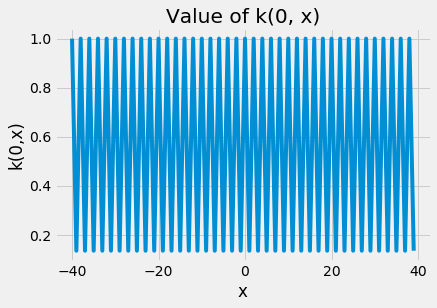

In [196]:
explore_kernel(ESS(length_scale=1, periodicity=2))

## Part II: Combining Kernels

Summation

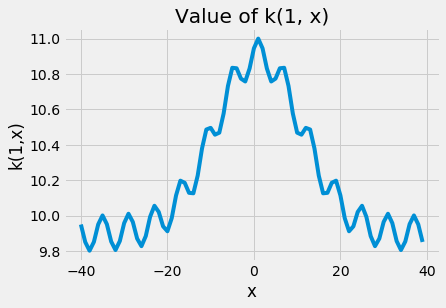

In [188]:
explore_kernel(10*ESS(length_scale=10, periodicity=1.2)+1.0*RBF(length_scale=10), x_0=1)

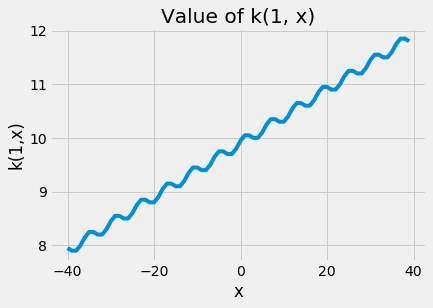

In [189]:
explore_kernel(10*ESS(length_scale=10, periodicity=1.2)+0.05*DotProduct(sigma_0=0), x_0=1)

Multiplication

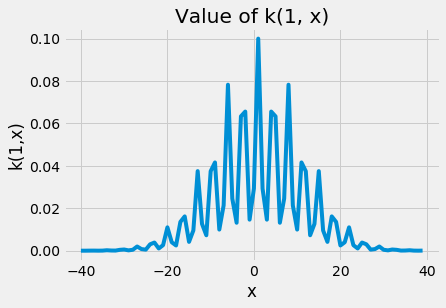

In [217]:
explore_kernel(10*ESS(length_scale=1, periodicity=1.4)*0.01*RBF(length_scale=10), x_0=1)

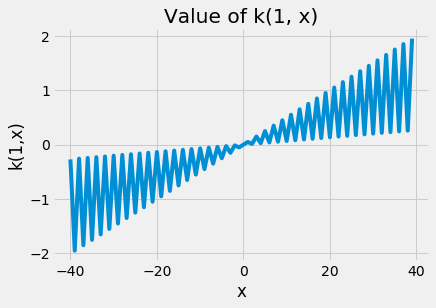

In [206]:
explore_kernel(10*ESS(length_scale=1, periodicity=2)*0.005*DotProduct(sigma_0=0), x_0=1)

## Part III: Data Loading

"Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.," which collected CO2 samples from March 1958 to December 2001. 

Reference: http://cdiac.ess-dive.lbl.gov/trends/co2/sio-keel-flask/sio-keel-flaskmlo_c.html

In [171]:
df = pd.read_csv('../../data/maunaloa.co2', comment = '*', sep = '\t',
                names = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                           'Aug','Sep', 'Oct', 'Nov', 'Dec', 'Average'])

# convert string values into NaNs by 'coerce' option.
df['Year'] = df['Year'].apply(pd.to_numeric, errors = 'coerce')
df = df[df['Year'].notnull()] # drop NaNs
df.pop('Average') # drop the average co2 values

# populate data
date = []
co2s = []
for year in range(1958, 2009):
    for month in range(1, 13):
        date.append(year + month/12)
    co2s.append(df.iloc[year - 1958,1:].astype('float64'))

# convert to numpy arrays
date = np.array(date)
co2 = pd.concat(co2 for co2 in co2s).values

# drop imputed vals
date = date[co2 > 0]
co2 = co2[co2 > 0]

# construct training data
X_obs = np.array(date, ndmin = 2).T
f_obs = co2

In [56]:
print(X_obs.shape)
print(f_obs.shape)
print(X_obs[0])
print(f_obs[0])

(607, 1)
(607,)
[ 1958.25]
315.7


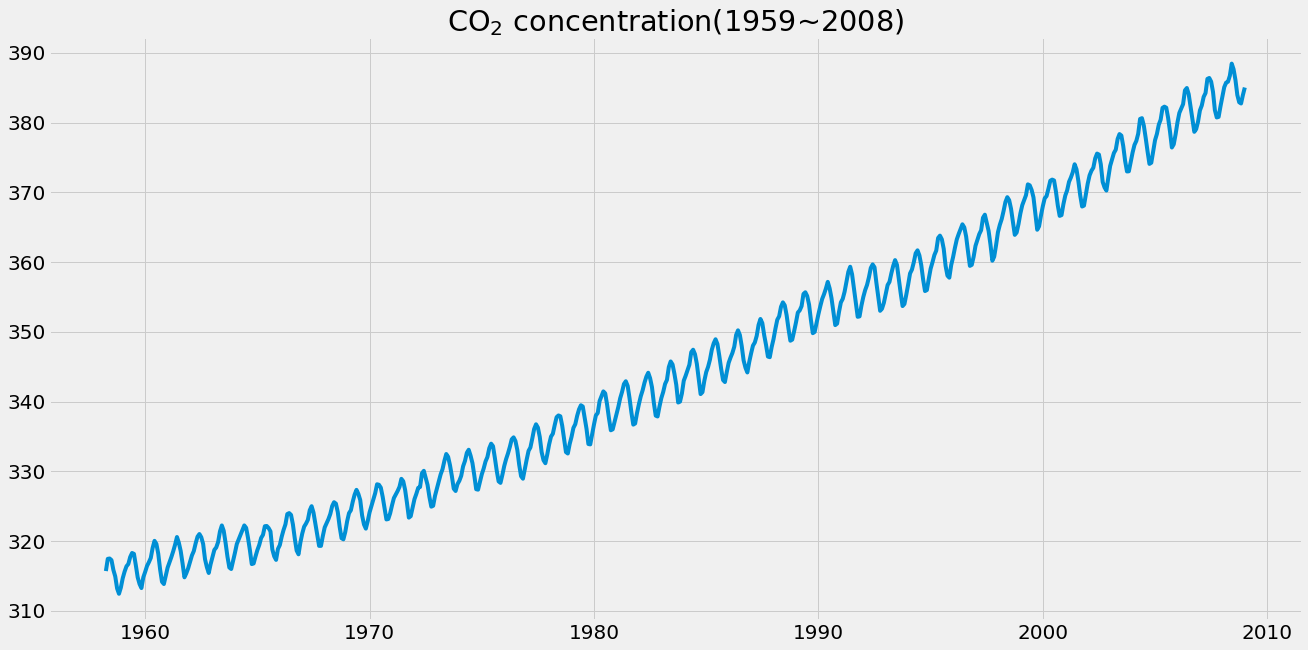

In [58]:
plt.figure(figsize=(20,10))
plt.plot(X_obs,f_obs)
plt.title(r"CO$_2$ concentration(1959~2008)")
plt.show()

## Part IV: Fit a Gaussian Process Regressor using SKLearn

In [50]:
def summary(gp):
    optimized = gp.optimizer != None
    if not optimized:
        s1 = "Fitted Kernel(not optimized)\n\n%s" % gp.kernel_
    else:
        s1 = "Fitted Kernel(Optimized)\n\n%s" % gp.kernel_
    s2 = "\n\nlog marginal likelihood: %.5f" % gp.log_marginal_likelihood(gp.kernel_.theta)
    print(s1 + s2 + '\n')

Default parameters w/o learning gives very bad performance.

In [218]:
# construct kernels
k1 = RBF()  # a long-term rising trend
k2 = RBF() * ESS()  # seasonal variation
k3 = RQ() # irregularity
k4 = RBF() + WK()  # noise
kernel = k1 + k2 + k3 + k4

# Fit without optimization
gp = GPR(kernel=kernel, alpha = 0, optimizer = None, normalize_y = True)
gp.fit(X_obs, f_obs)

summary(gp)

Fitted Kernel(not optimized)

RBF(length_scale=1) + RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=1) + RationalQuadratic(alpha=1, length_scale=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1)

log marginal likelihood: -2171.87376



fit() methods automatically finds the parameters using MLE.

In [219]:
# construct kernels
k1 = RBF()  # a long-term rising trend
k2 = RBF() * ESS()  # seasonal variation
k3 = RQ() # irregularity
k4 = RBF() + WK()  # noise
kernel = k1 + k2 + k3 + k4

# Fit with optimization
gp = GPR(kernel=kernel, alpha = 0, normalize_y = True)
gp.fit(X_obs, f_obs)

summary(gp)

Fitted Kernel(Optimized)

RBF(length_scale=12.8) + RBF(length_scale=22.2) * ExpSineSquared(length_scale=1.25, periodicity=1) + RationalQuadratic(alpha=0.387, length_scale=1.29) + RBF(length_scale=12.8) + WhiteKernel(noise_level=0.0572)

log marginal likelihood: -561.28492



Hyperparameters from the GPML book, where the first element is a dummy.

http://www.gaussianprocess.org/gpml/

In [61]:
# construct kernels
t = [None, 66, 67, 2.4, 90, 1.3, 0.66, 1.2, 0.78, 0.18, 1.6, 0.19]
k1 = t[1]**2 * RBF(length_scale=t[2])  # a long-term rising trend
k2 = t[3]**2 * RBF(length_scale=t[4]) * ESS(length_scale=t[5], periodicity=1)  # seasonal variation
k3 = t[6]**2 * RQ(length_scale=t[7], alpha=t[8]) # irregularity
k4 = t[9]**2 * RBF(length_scale=t[10]) + WK(t[11])  # noise
kernel = k1 + k2 + k3 + k4

# Fit without optimization
gp = GPR(kernel=kernel, alpha = 0, optimizer = None, normalize_y = True)
gp.fit(X_obs, f_obs)

summary(gp)

Fitted Kernel(not optimized)

66**2 * RBF(length_scale=67) + 2.4**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1.3, periodicity=1) + 0.66**2 * RationalQuadratic(alpha=0.78, length_scale=1.2) + 0.18**2 * RBF(length_scale=1.6) + WhiteKernel(noise_level=0.19)

log marginal likelihood: -286.27123



In [62]:
# Optimal hyperparameters derived from the past fitting
t_opt = [None, 85.7, 80, 2.4, 174, 1.27, 1.65, 1.06, 0.0112, 0.552, 2.72, 0.0392]
k1_opt = t_opt[1]**2 * RBF(length_scale=t_opt[2])  # a long-term rising trend
k2_opt = t_opt[3]**2 * RBF(length_scale=t_opt[4]) *\
ESS(length_scale=t_opt[5], periodicity=1)  # seasonal variation
k3_opt = t_opt[6]**2 * RQ(length_scale=t_opt[7], alpha=t_opt[8]) # irregularity
k4_opt = t_opt[9]**2 * RBF(length_scale=t_opt[10]) + WK(t_opt[11])  # noise
kernel_opt = k1_opt + k2_opt + k3_opt + k4_opt

gp_opt = GPR(kernel = kernel_opt, alpha = 0, optimizer = None, normalize_y = True)
gp_opt.fit(X_obs, f_obs)

summary(gp_opt)

Fitted Kernel(not optimized)

85.7**2 * RBF(length_scale=80) + 2.4**2 * RBF(length_scale=174) * ExpSineSquared(length_scale=1.27, periodicity=1) + 1.65**2 * RationalQuadratic(alpha=0.0112, length_scale=1.06) + 0.552**2 * RBF(length_scale=2.72) + WhiteKernel(noise_level=0.0392)

log marginal likelihood: -140.70012



## Part V: Model Performance

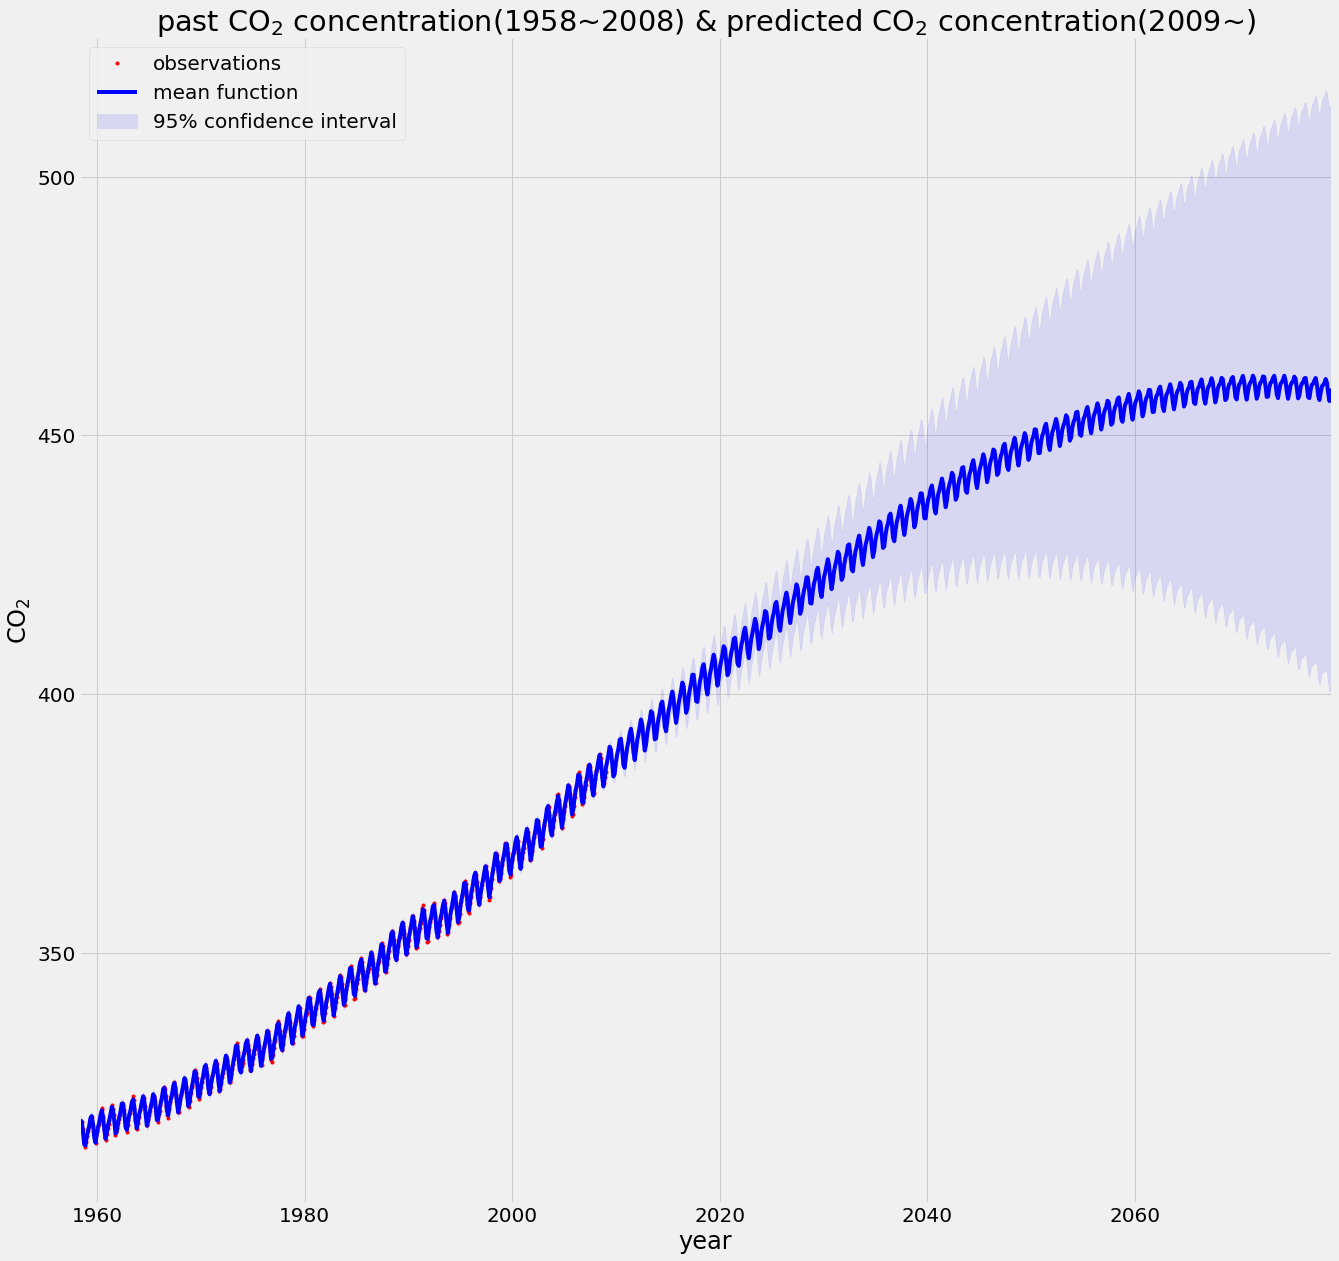

In [63]:
# Predict on future test points
X_test = np.array(np.linspace(X_obs.min(), X_obs.max() + 70, 1000), ndmin = 2).T
f_mean, f_std = gp.predict(X_test, return_std=True)

# Create a figure
fig_co2 = plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 20})

# Mark the observations
plt.plot(X_obs, f_obs, 'r.', label='observations')

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='mean function')
upper_bound = f_mean + 1.96 * f_std
lower_bound = f_mean - 1.96 * f_std
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='95% confidence interval')

# Draw samples from the posterior and plot
plt.xlabel('year')
plt.ylabel(r"CO$_2$")
plt.xlim(X_test.min(), X_test.max())
plt.legend(loc='upper left')
plt.title(r"past CO$_2$ concentration(1958~2008) & predicted CO$_2$ concentration(2009~)")
plt.show()

### You don't need to turn in this lab.

### Reference

Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A., http://cdiac.ess-dive.lbl.gov/trends/co2/sio-keel-flask/sio-keel-flaskmlo_c.html

Gaussian Process Regression with scikit-learn for the GPML, https://yhs-968.github.io/ml/2017/02/13/Gaussian-Process-Regression-with-scikit-learn-for-the-GPML.html